<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='40%'></img>

<br>

<a href="./00_index.ipynb"><< Index </a><br>
<a href="./03_sentinel3_OLCI_L1_load_browse.ipynb"><< 03 - Sentinel-3 OLCI Level-1B - Load and browse </a><span style="float:right;"><a href="./05_sentinel3_NRT_SLSTR_AOD_load_browse.ipynb">05 - Sentinel-3 NRT SLSTR AOD - Load and browse >></a></span>

<br>

<div class="alert alert-block alert-warning">
<b>LOAD, BROWSE AND VISUALIZE</b></div>

# Sentinel-3 Near Real Time SLSTR Fire Radiative Power (FRP)

##  Example Siberian fires in June 2020

The following workflow is based on an example of `Sentinel-3 Near Real Time SLSTR FRP` data on 27 June 2020. As a comparison, you see below the Sentinel-3 OLCI Red Green Blue composites for the same day, which clearly shows the smoke plumes along the Californian coast resulting from the fires.


<div style='text-align:center;'>
<figure><img src='./img/s3_olci_0727.png' width='80%'/>
    <figcaption><i>RGB composites of Sentinel-OLCI Level 1 data on 27 June 2020</i></figcaption>
</figure>
</div>
   

<hr>

### Outline
* [1 - Load Sentinel-3 NRT SLSTR FRP data](#load_s3_frp)
* [2 - Load, mask and regrid FRP computed from MWIR channel (3.7 um)](#load_mwir)
* [3 - Load, mask and regrid FRP computed from SWIR channel (2.25 um)](#load_swir)
* [4 - Load, mask and regrid FRP computed from SWIR channel (2.25 um) with SAA filter applied](#load_swir_nosaa)

<hr>

#### Load required libraries

In [16]:
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as pltfacebook
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load helper functions

In [17]:
from ipynb.fs.full.functions import generate_masked_array, visualize_s3_frp, slstr_frp_gridding

<hr>

## <a id='load_s3_frp'></a>Load Sentinel-3 Near Real Time SLSTR FRP data

Sentinel-3 Near Real Time SLSTR FRP data are disseminated  in `netCDF` format. The first step is to load the data file with xarray's `open_dataset()` function.


<br>

### Load `S3 NRT SLSTR FRP` data with xarray's `open_dataset()` function

Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are three variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW]
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW]
- `FLAG_SWIR_SAA` - Flag values to filter out South Atlantic Anomalies (SAA) & other transient / spurious events, only applicable to FRP SWIR

In [18]:
frp_dir = '../eodata/sentinel3/slstr/2020/06/27/'
frp_xr = xr.open_dataset(frp_dir+'FRP_in_Siberia_202000627.nc')
frp_xr

<xarray.Dataset>
Dimensions:                 (columns: 1500, fires: 1108, rows: 2000)
Dimensions without coordinates: columns, fires, rows
Data variables:
    i                       (fires) int16 ...
    j                       (fires) int32 ...
    time                    (fires) datetime64[ns] ...
    latitude                (fires) float64 ...
    longitude               (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    transmittance_MWIR      (fires) float64 ...
    FRP_SWIR                (fires) float64 ...
    FRP_uncertainty_SWIR    (fires) float64 ...
    FLAG_SWIR_SAA           (fires) int16 ...
    transmittance_SWIR      (fires) float64 ...
    confidence              (fires) float64 ...
    classification          (fires) uint8 ...
    S7_Fire_pixel_radiance  (fires) float32 ...
    F1_Fire_pixel_radiance  (fires) float32 ...
    used_channel            (fires) uint8 ...
    Radiance_window         (fires) float32 ...
    Glint_angle             (fires) float64 ...
    IFOV_area               (fires) float64 ...
    TCWV                    (fires) float64 ...
    n_window                (fires) int16 ...
    n_water                 (fires) int16 ...
    n_cloud                 (fires) int16 ...
    n_SWIR_fire             (fires) float32 ...
    flags                   (rows, columns) uint32 ...
Attributes:
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20200627T111323_20200627T111823_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 02.00
    history:                 
    references:             S3MPC ACR FRP 003 - i1r2 - SLSTR L2 Product Data ...
    contact:                ops@eumetsat.int
    creation_time:          2020-06-27T13:46:19Z
    resolution:             [ 1000 1000 ]
    absolute_orbit_number:  22711
    start_time:             2020-06-27T11:13:22.962714Z
    stop_time:              2020-06-27T11:18:22.948658Z
    track_offset:           998
    start_offset:           5632

<br>

### Load `latitude` and `longitude` information

You can already load the `latitude` and `longitude` information, which will be required for the regridding process.

In [19]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lat_frp.data.max()

67.7314998289944

<br>

### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `gridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

In [20]:
sampling_lat_FRP_grid = 0.05        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.05        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 40.         # Max Integrated FRP value, for plots


lat_min               = 50.        # Minimum latitude for mapping plot [deg N]
lat_max               = 72.        # Maximum latitude for mapping plot [deg N]
lon_min               = 120.        # Minimum lonitude for mapping plot [deg E]
lon_max               = 170.        # Maximum lonitude for mapping plot [deg E]

<br>

Now, let us go through the three different variables (`MWIR`, `SWIR` and `SWIR with SAA filtered out`) and let us load, mask, regrid and visualize them.

<br>

## <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. You, see that the variable contains 983 fire entries.

In [21]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 1108)>
array([ 8.712728,  3.450277, 27.888621, ...,  3.480033,  3.40337 ,  2.624291])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

<br>

The next step is to extract (mask) only the right FRP pixels. Valid pixels are different to -1. You can use the function [generate_masked_array](./functions.ipynb#generate_masked_array) to extract the right pixels.

In [22]:
masked_frp_mwir = generate_masked_array(frp_mwir, frp_mwir, -1.,operator='!=', drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (fires: 1108)>
array([ 8.71272752,  3.45027709, 27.88862075, ...,  3.4800329 ,
        3.40336956,  2.62429088])
Dimensions without coordinates: fires


<xarray.DataArray 'FRP_MWIR' (fires: 1108)>
array([ 8.71272752,  3.45027709, 27.88862075, ...,  3.4800329 ,
        3.40336956,  2.62429088])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

<br>

Let us retrieve the number of of hotspots / fires in total and per category.

In [23]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(1108, 1108)

<br>

### Generate a gridded FRP array

Let us compute the gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
You can define the function [slstr_frp_gridding](./functions.ipynb#slstr_frp_gridding) and you can then reuse it to apply it for other data variables.

In [24]:
def slstr_frp_gridding(parameter_array, lat_frp, lon_frp, parameter, lat_min, lat_max, lon_min, lon_max, sampling_lat, sampling_lon, n_fire, **kwargs):
    n_lat = int( (np.float32(lat_max) - np.float32(lat_min)) / sampling_lat_FRP_grid ) + 1 # Number of rows per latitude sampling
    n_lon = int( (np.float32(lon_max) - np.float32(lon_min)) / sampling_lon_FRP_grid ) + 1 # Number of lines per longitude sampling

    
    slstr_frp_gridded = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.

    lat_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    lon_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    
    if (n_fire >= 0):
    
    # Loop on i_lat: begins
        for i_lat in range(n_lat):
                    
        # Loop on i_lon: begins
            for i_lon in range(n_lon):
                        
                lat_grid[i_lat, i_lon] = lat_min + np.float32(i_lat) * sampling_lat_FRP_grid + sampling_lat_FRP_grid / 2.
                lon_grid[i_lat, i_lon] = lon_min + np.float32(i_lon) * sampling_lon_FRP_grid + sampling_lon_FRP_grid / 2.
                            
            # Gridded SLSTR FRP MWIR Night - All days
                if(parameter=='swir_nosaa'):
                    FLAG_FRP_SWIR_SAA_nc = kwargs.get('flag', None)
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.) & (FLAG_FRP_SWIR_SAA_nc[:] == 0), False, True)
                else:
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.),  False, True)
                            
                masked_slstr_frp_grid = np.ma.array(parameter_array[:], mask=mask_grid)
                            
                if len(masked_slstr_frp_grid.compressed()) != 0:
                    slstr_frp_gridded[i_lat, i_lon]  = np.sum(masked_slstr_frp_grid.compressed())
    return slstr_frp_gridded, lat_grid, lon_grid
    

<br>

Apply the function `slstr_frp_gridding` to the `frp_mwir` data array.

In [25]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(frp_mwir,
                                                       lat_frp,
                                                       lon_frp,
                                                       'mwir', 
                                                       lat_min, lat_max, lon_min, lon_max, 
                                                       sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid, 
                                                       n_fire_MWIR)

FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[50.025, 50.025, 50.025, ..., 50.025, 50.025, 50.025],
        [50.075, 50.075, 50.075, ..., 50.075, 50.075, 50.075],
        [50.125, 50.125, 50.125, ..., 50.125, 50.125, 50.125],
        ...,
        [71.925, 71.925, 71.925, ..., 71.925, 71.925, 71.925],
        [71.975, 71.975, 71.975, ..., 71.975, 71.975, 71.975],
        [72.025, 72.025, 72.025, ..., 72.025, 72.025, 72.025]],
       dtype=float32),
 array([[120.025, 120.075, 120.125, ..., 169.925, 169.975, 170.025],
        [120.025, 120.075, 120.125, ..., 169.925, 169.975, 170.025],
        [120.025, 120.075, 120.1

<br>

Mask out the invalid pixels for plotting. You can use numpy's function `np.ma.masked_array()` for this.

In [26]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

<br>

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [27]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



<br>

### Visualize the masked data array with matplotlib's `pcolormesh()` function

You can define function for the plotting code, so it can be easily re-used to plot other FRP data variables. Let us call the function [visualize_s3_frp](./functions.ipynb#visualize_s3_frp).

The function takes the following keyword arguments:
* `data`: DataArray with fire hotspots
* `lat`: Latitude information
* `lon`: Longitude information
* `unit`: Unit of the data
* `longname`: Long name of the data
* `textstr_1`: Text that contains the total number of 1km hot-spots
* `textstr_2`: Text that contains summary statistics of the data
* `vmax`: Maximum value to be visualized

In [28]:
def visualize_s3_frp(data, lat, lon, unit, longname, textstr_1, textstr_2, vmax):
    fig=plt.figure(figsize=(20, 15))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.pcolormesh(lon, lat, data, 
                        cmap=cm.autumn_r, transform=ccrs.PlateCarree(),
                        vmin=0,
                        vmax=vmax)

    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.bottom_labels=False
    gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.029, pad=0.025)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(longname, fontsize=20, pad=40.0) 

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box on the right side of the plot
    ax.text(1.1, 0.9, textstr_1, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(1.1, 0.85, textstr_2, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    plt.show()

                                

<br>

Now, you can apply the function `visualize_s3_frp` and plot the `FRP computed from MWIR channel` data. Additionally, you can take information such as `longname` or `units` from the data variable attributes.

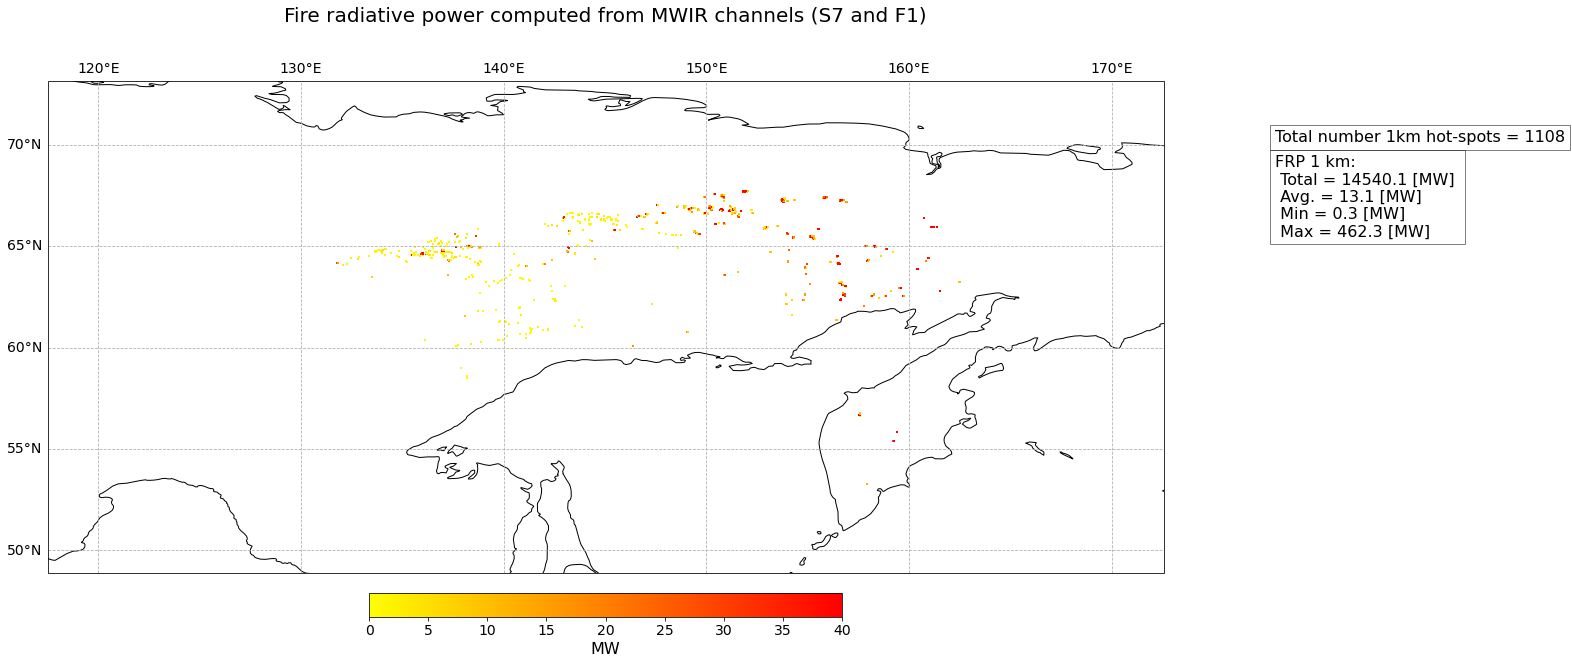

In [30]:
long_name = frp_mwir.long_name
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(D_mwir[:,:],
                 lat_grid, 
                 lon_grid, 
                 unit, 
                 long_name, 
                 textstr_1, 
                 textstr_2, 
                 FRP_plot_max_grid)

<br>

<br>

<br>

<a href="./00_index.ipynb"><< Index </a><br>
<a href="./03_sentinel3_OLCI_L1_load_browse.ipynb"><< 03 - Sentinel-3 OLCI Level-1B - Load and browse </a><span style="float:right;"><a href="./05_sentinel3_NRT_SLSTR_AOD_load_browse.ipynb">05 - Sentinel-3 NRT SLSTR AOD - Load and browse >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.